## Linear Regression

We are looking at a housing dataset from Ames, Iowa, US from 2006 to 2010.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [14]:
data = pd.read_csv('AmesHousing.tsv', sep='\t')

In [131]:
def transform_features(data):
    '''
    Remove features based on missing or data leakage
    Transforms features: (numerical to categorical, scaling numerical, filling NA)
    Creates new features
    '''
    num_missing = data.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(data)/20)].sort_values()
    data = data.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = data.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    data = data.drop(drop_missing_cols_2.index, axis=1)
    # Numerical columns
    num_missing = data.select_dtypes(include=['float', 'int']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(data)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = data[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    data = data.fillna(replacement_values_dict)
    
    ## Create new features
    year_sold = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    # Add new features
    data['years_sold'] = year_sold
    data['years_remod'] = years_since_remod
    ## Drop irregular data from new cols
    data = data.drop([1702, 2180, 2181], axis=0)
    ## Drop previous columns
    data = data.drop(['Year Built', 'Year Remod/Add'], axis=1)
    ## Drop Useless columns
    data = data.drop(['PID', 'Order'], axis=1)
    ## Drop Leakage columns
    data = data.drop(['Mo Sold', 'Yr Sold'], axis=1)
    return data

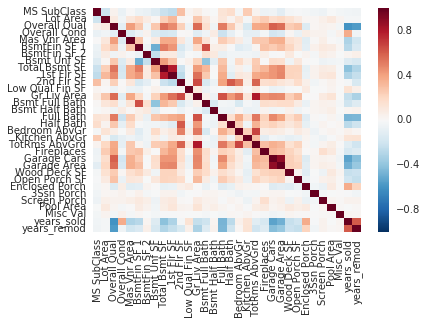

In [132]:
# Correlation in data Features 
features = transform_features(data).drop(['SalePrice'], axis=1)
sns.heatmap(features.corr())

In [133]:
# Features correlated with the target
abs(transform_features(data).corr()['SalePrice']).sort_values(ascending=False).head(15)

SalePrice        1.000000
Overall Qual     0.801206
Gr Liv Area      0.717596
Garage Cars      0.648361
Total Bsmt SF    0.644012
Garage Area      0.641425
1st Flr SF       0.635185
years_sold       0.558979
Full Bath        0.546118
years_remod      0.534985
Mas Vnr Area     0.506983
TotRms AbvGrd    0.498574
Fireplaces       0.474831
BsmtFin SF 1     0.439284
Wood Deck SF     0.328183
Name: SalePrice, dtype: float64

In [134]:
def select_features(data, threshold=0.4, unique_threshold=10):
    numerical_df = data.select_dtypes(include=['int','float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    data = data.drop(abs_corr_coeffs[abs_corr_coeffs < threshold].index, axis=1)
    # Documented categorical features
    categorical = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    # Filtering dataset with categorical data
    categorical_cols = []
    for col in categorical:
        if col in data.columns:
            categorical_cols.append(col)
    
    unique_counts = data[categorical_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_unique_cols = unique_counts[unique_counts > 10].index
    
    data = data.drop(drop_unique_cols, axis=1)
    
    # Text data
    text_cols = data.select_dtypes(include=['object'])
    for col in text_cols:
        data[col] = data[col].astype('category')
    
    data = pd.concat([data, pd.get_dummies(data.select_dtypes(include=['category']))], axis=1).drop(text_cols, axis=1)
    
    return data

In [151]:
def train_and_test(data, k=0):

    #Choose numerical features
    features = data.select_dtypes(include=['float', 'int']).columns.drop('SalePrice',axis=1)
    labels = data['SalePrice']
    model = LinearRegression()
    
    if k == 0:
        # Split dataset
        train = data[:1460, :]
        test = data[1460:, :]
        # Train model
        model.fit(train[features], train['SalePrice'])
        # Predict test
        predictions = model.predict(test[features])
        
        mse = mean_squared_error(test['SalePrice'], predictions)
        rmse = np.sqrt(mse)
        return rmse
    if k == 1:
        shuffle_data = data.sample(frac=1, )
        train = data[:1460]
        test = data[1460:]
        model.fit(train[features], train['SalePrice'])
        predictions_one = model.predict(test[features])
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        model.fit(test[features], test['SalePrice'])
        predictions_two = model.predict(train[features])
        
        mse_two = mean_squared_error(train['SalePrice'], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            model.fit(train[features], train['SalePrice'])
            predictions = model.predict(test[features])
            
            mse = mean_squared_error(test['SalePrice'], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [152]:
transform_df = transform_features(data)
filtered_df = select_features(transform_df)

In [153]:
rmse = train_and_test(filtered_df, k=4)
rmse

ValueError: Must pass DataFrame with boolean values only